In this Notebook I will show how to solve Fashion MNIST dataset with Convolutional Neural Network.

### Import

In [0]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random as rn
import numpy as np

# Randomness control
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

### Constants

In [0]:
CLASS_NUMBER = 10

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUM_CHANNELS = 1

TRAIN_IMAGE_NUMBER = 60000
TEST_IMAGE_NUMBER = 10000

### Loading Data

Fashion MNIST data is being built into ``from keras.datasets`` module.

In [0]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

### Data Visualisation

In [0]:
def show_images(X_train, y_train, rows_num=6):    
    figure, axes = plt.subplots(nrows=rows_num, ncols=6, sharex=True, sharey=True, figsize=(20, rows_num * 2))
    
    for row_index in range(rows_num):
        ax_row = axes[row_index]
        images = X_train[(row_index*8):(row_index+1)*8]
        labels = y_train[(row_index*8):(row_index+1)*8]
        
        for ax, img, label in zip(ax_row, images, labels):
            ax.imshow(img, cmap='gray_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("Label - {}".format(label))

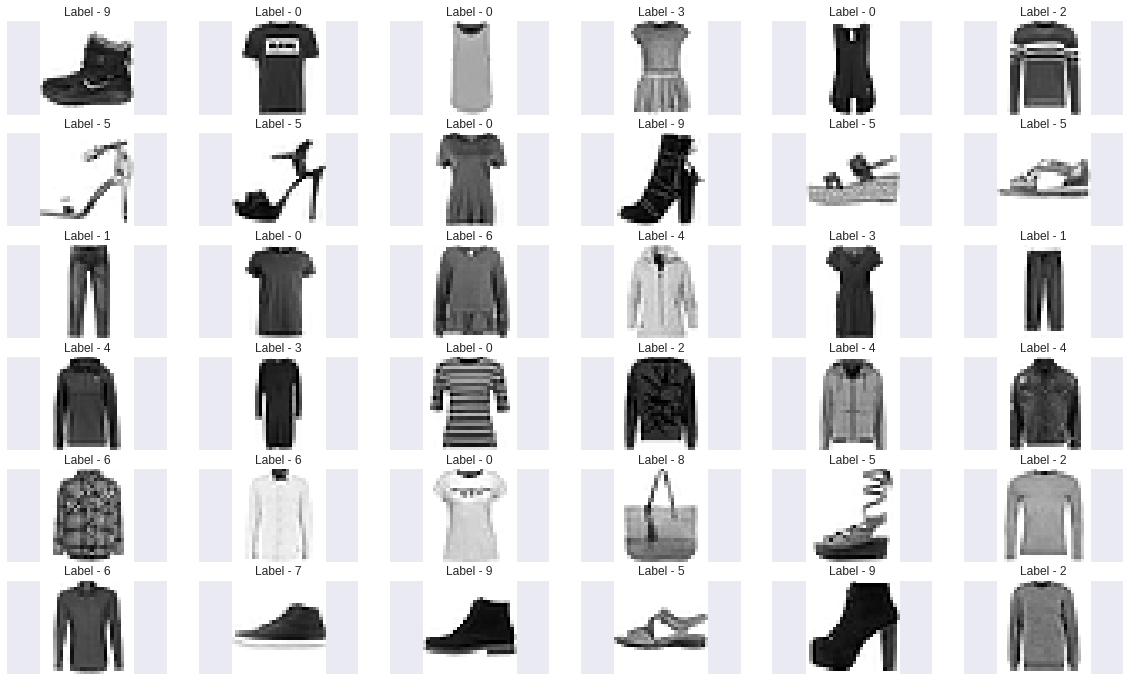

In [64]:
show_images(X_train, y_train)

### Data Preprocessing

Preparing data shape for CNN input - including channel num.

In [65]:
print("Training data - before reshape: ")
print(" - min: {}".format(X_train.shape))
print(" - max: {}".format(X_train.shape))

X_train = X_train.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1)
X_test = X_test.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1)

print("\nTest data - after reshape: ")
print(" - min: {}".format(X_test.shape))
print(" - max: {}".format(X_test.shape))

Training data - before reshape: 
 - min: (60000, 28, 28)
 - max: (60000, 28, 28)

Test data - after reshape: 
 - min: (10000, 28, 28, 1)
 - max: (10000, 28, 28, 1)


Normalization

In [66]:
print("Training data - before normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("\nTraining data - after normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

Training data - before normalization: 
 - min: 0
 - max: 255
Test data - after normalization: 
 - min: 0
 - max: 255

Training data - after normalization: 
 - min: 0.0
 - max: 1.0
Test data - after normalization: 
 - min: 0.0
 - max: 1.0


One-Hot Encoding

In [67]:
print("Train data labels - before OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - before OHE: ")
print(" - example: {}\n".format(y_test[:10]))

y_train = keras.utils.to_categorical(y_train, CLASS_NUMBER)
y_test = keras.utils.to_categorical(y_test, CLASS_NUMBER)

print("\nTrain data labels - after OHE: ")
print(" - example: \n{}".format(y_train[:10]))
print("Test data labels - after OHE: ")
print(" - example: \n{}".format(y_test[:10]))

Train data labels - before OHE: 
 - example: [9 0 0 3 0 2 7 2 5 5]

Test data labels - before OHE: 
 - example: [9 2 1 1 6 1 4 6 5 7]


Train data labels - after OHE: 
 - example: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Test data labels - after OHE: 
 - example: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


### Train/Validation data split

In [68]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (48000, 28, 28, 1)
y_train_input shape: (48000, 10)
X_val_input shape: (12000, 28, 28, 1)
y_val_input shape: (12000, 10)


### Model

Creation

In [69]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), padding="same", use_bias=False,
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS),
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(16, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", use_bias=False,
                 kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, use_bias=False, 
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(128, use_bias=False, 
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(CLASS_NUMBER, 
                activation="softmax",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
    
model.compile(loss="categorical_crossentropy", optimizer=Adam(), 
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_34 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_34 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 16)        2304      
_________________________________________________________________
batch_normalization_35 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_35 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 28, 28, 16)        0         
__________

Training

In [70]:
history = model.fit(X_train_input, y_train_input,
                    batch_size=64,
                    epochs=50,
                    verbose=2,
                    validation_data=(X_val_input, y_val_input))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
 - 16s - loss: 0.4129 - acc: 0.8503 - val_loss: 0.4116 - val_acc: 0.8414
Epoch 2/50
 - 14s - loss: 0.2826 - acc: 0.8947 - val_loss: 0.3687 - val_acc: 0.8600
Epoch 3/50
 - 14s - loss: 0.2478 - acc: 0.9079 - val_loss: 0.3483 - val_acc: 0.8752
Epoch 4/50
 - 14s - loss: 0.2237 - acc: 0.9179 - val_loss: 0.2794 - val_acc: 0.8986
Epoch 5/50
 - 14s - loss: 0.2064 - acc: 0.9227 - val_loss: 0.3580 - val_acc: 0.8742
Epoch 6/50
 - 14s - loss: 0.1937 - acc: 0.9263 - val_loss: 0.2489 - val_acc: 0.9093
Epoch 7/50
 - 14s - loss: 0.1807 - acc: 0.9321 - val_loss: 0.3203 - val_acc: 0.8818
Epoch 8/50
 - 14s - loss: 0.1707 - acc: 0.9358 - val_loss: 0.2806 - val_acc: 0.8991
Epoch 9/50
 - 14s - loss: 0.1567 - acc: 0.9408 - val_loss: 0.2954 - val_acc: 0.8927
Epoch 10/50
 - 14s - loss: 0.1508 - acc: 0.9422 - val_loss: 0.2464 - val_acc: 0.9100
Epoch 11/50
 - 14s - loss: 0.1389 - acc: 0.9474 - val_loss: 0.2555 - val_acc: 0.9050
Epoch 12/50
 - 14s - los

 - 15s - loss: 0.0493 - acc: 0.9813 - val_loss: 0.2433 - val_acc: 0.9231
Epoch 35/50
 - 15s - loss: 0.0526 - acc: 0.9800 - val_loss: 0.2525 - val_acc: 0.9222
Epoch 36/50
 - 15s - loss: 0.0476 - acc: 0.9821 - val_loss: 0.2576 - val_acc: 0.9213
Epoch 37/50
 - 15s - loss: 0.0483 - acc: 0.9818 - val_loss: 0.2748 - val_acc: 0.9185
Epoch 38/50
 - 15s - loss: 0.0438 - acc: 0.9834 - val_loss: 0.3150 - val_acc: 0.9104
Epoch 39/50
 - 15s - loss: 0.0438 - acc: 0.9840 - val_loss: 0.2636 - val_acc: 0.9231
Epoch 40/50
 - 15s - loss: 0.0452 - acc: 0.9831 - val_loss: 0.2684 - val_acc: 0.9217
Epoch 41/50
 - 15s - loss: 0.0441 - acc: 0.9839 - val_loss: 0.2758 - val_acc: 0.9187
Epoch 42/50
 - 15s - loss: 0.0392 - acc: 0.9856 - val_loss: 0.2536 - val_acc: 0.9239
Epoch 43/50
 - 15s - loss: 0.0389 - acc: 0.9856 - val_loss: 0.2870 - val_acc: 0.9178
Epoch 44/50
 - 15s - loss: 0.0389 - acc: 0.9859 - val_loss: 0.2615 - val_acc: 0.9243
Epoch 45/50
 - 15s - loss: 0.0384 - acc: 0.9864 - val_loss: 0.2757 - val_acc:

Evaluation

In [71]:
train_score = model.evaluate(X_train_input, y_train_input, verbose=0)
val_score = model.evaluate(X_val_input, y_val_input, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
  
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.042615869593651344
 - acc: 0.9858333333333333
Validation data results:
 - error: 0.25336028543735545
 - acc: 0.92575
Test data results:
 - error: 0.2777278567314148
 - acc: 0.9214


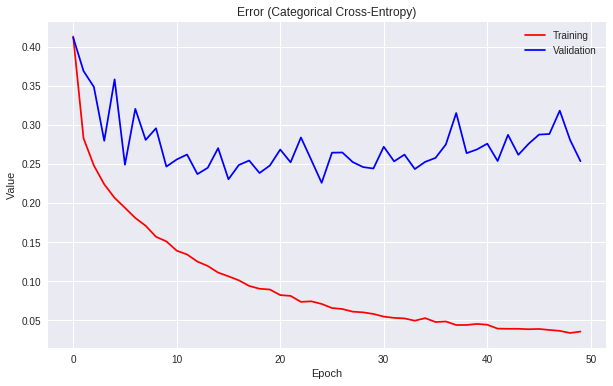

In [72]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");